## Model Selection and Visualization

For the music recommendation systems based on the Spotify Millions Dataset we go ahead with an Unsupervised Model - K Means Clustering.

### 📝Steps for Visualization

1. In order to cluster the features on a 2-D space, we need to bring down the N-dimentional playlist features dataframe to 2-Dimentional space using a method called **t-SNE**

2. After getting the data in 2-D space we visualize the data using scatter plot

3. We try using arbitrary value of K (Clusters) to get the plots


In order to determine the best value of **K** we will need to **train the K means model on various values of K and decide the best K** based on some performance metrics like - Silhouette, Davies-Bouldin and Calinski-Harabasz etc.,

### 1. Getting the multidimentional data into 2-D

### What is t-SNE?

t-SNE(t-distributed Stochastic Neighbor Embedding) is a dimensionality reduction algorithms like PCA. t-SNE is sometimes called **nonlinear dimensionality reduction**. What that means is this algorithm allows us to separate data that cannot be separated by any straight line

![0 rPhupOA95cU_GmCD](https://user-images.githubusercontent.com/13203059/164562149-457cec3d-5fa8-4105-af39-691b8ac603ac.png)


In [1]:
import os
import re
import sys
import json
import config
import random
import pickle
import spotipy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.manifold import TSNE
from openTSNE import TSNE as openTSNE
from scipy.spatial.distance import cdist
from sklearn.dummy import DummyRegressor
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from IPython.display import SVG, display, Image
from sklearn.preprocessing import StandardScaler
from spotipy.oauth2 import SpotifyClientCredentials, SpotifyOAuth
from sklearn.cluster import  KMeans
from sklearn.metrics import mean_squared_error, mean_absolute_error, silhouette_score, pairwise_distances, davies_bouldin_score, calinski_harabasz_score


In [5]:
df = pd.read_csv('../data/2022_20_20_00_58_35_Playlist_Feats_20000.csv')
df.head()

,name,pid,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Throwbacks,0,0.664077,0.781077,5.038462,-4.891212,0.692308,0.103698,0.083674,0.000674,0.187087,0.642750,121.157500,221777.461538,4.000000
1,Awesome Playlist,1,0.492382,0.695923,4.461538,-8.107974,0.538462,0.091010,0.162227,0.223708,0.179344,0.476667,124.987128,298837.641026,3.769231
2,korean,2,0.671062,0.692953,5.000000,-4.875594,0.515625,0.096425,0.269100,0.000638,0.168894,0.565078,114.595984,219373.953125,4.000000
3,mat,3,0.514429,0.620902,5.103175,-9.618754,0.714286,0.067000,0.273514,0.203156,0.188278,0.451258,125.547627,229575.055556,3.952381
4,90s,4,0.576235,0.650418,3.352941,-7.634529,0.823529,0.041218,0.177189,0.081759,0.166524,0.490294,127.725412,255014.352941,3.941176


In [4]:
feat_cols_user = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
            'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']

In [6]:
scaler = StandardScaler(with_mean=True, with_std=True).fit(df[feat_cols_user])
scaled_data = scaler.transform(df[feat_cols_user])

In [7]:
feats_df = pd.DataFrame(scaled_data)
feats_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.612941,1.087351,-0.201763,0.996905,0.209481,0.192394,-0.913523,-0.473001,-0.006396,1.210250,-0.021030,-0.385641,0.589830
1,-1.181203,0.440253,-1.061757,-0.305002,-0.777695,-0.032531,-0.456447,1.291766,-0.186612,-0.100746,0.497435,1.926071,-1.767783
2,0.685938,0.417684,-0.259096,1.003225,-0.924229,0.063459,0.165413,-0.473290,-0.429831,0.597139,-0.909346,-0.457743,0.589830
3,-0.950825,-0.129847,-0.105298,-0.916454,0.350506,-0.458177,0.191097,1.129143,0.021330,-0.301313,0.573317,-0.151723,0.103339
4,-0.304969,0.094450,-2.714294,-0.113387,1.051484,-0.915238,-0.369389,0.168583,-0.484998,0.006823,0.868151,0.611426,-0.011130


#### Using t-SNE to do dimentionality reduction

In [8]:
# Getting TSNE with openTSNE
tsne = openTSNE(
    perplexity=30,
    metric="euclidean",
    n_jobs=-1,
    random_state=0,
    verbose=False,
)

tsne_transformer = tsne.fit(scaled_data)
df_opentsne = pd.DataFrame(tsne_transformer.transform(scaled_data),columns=['X','Y'])

In [9]:
df_opentsne.head()

,X,Y
0,-29.599429,-3.872502
1,14.377898,-0.830556
2,-25.912559,9.652334
3,11.911065,-1.565481
4,10.589357,-12.968207


### 2. Visualizing the 2-D data on a scatter plot

<AxesSubplot:xlabel='X', ylabel='Y'>

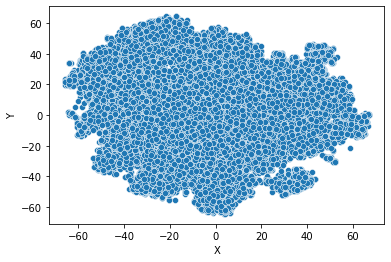

In [10]:
sns.scatterplot(x='X', y='Y', data=df_opentsne, legend=None)

### 3. Using K-Means and trying different values of K

In [27]:
def single_model_and_plot(model, K, df, df_clusters, title, random_state=0):
    try:
        clustering = model(n_clusters=K, random_state=random_state).fit(df)
    except TypeError:
        clustering = model(n_clusters=K).fit(df)
    df_clusters['cluster'] = pd.Categorical(clustering.labels_)
    
    fig = plt.figure(figsize=(20,20))
    
    plt.subplot(2,2,1)

    # norm = plt.Normalize(df_clusters['cluster'].min(), df_clusters['cluster'].max())
    # sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
    # sm.set_array([])

    # ax = sns.scatterplot(x='X', y='Y', data=df_clusters, marker='D', palette='RdBu', hue='mag')


    sns
    sns.scatterplot(x='X', y='Y', hue='cluster', style='cluster', marker='D', data=df_clusters, legend=None).set(title = f'SMD 20K playlists Clustering with K = {K}')
    # c = plt.colorbar()
    # plt.clim(1, K)
    # plt.show()

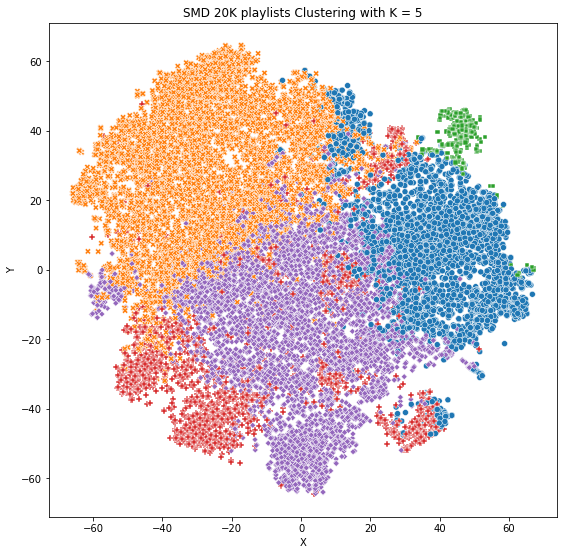

In [28]:
# KMeans with K = 5
single_model_and_plot(KMeans, K=5, df=scaled_data, df_clusters=df_opentsne, 
                      title='Clustering on scaled data', random_state=None)

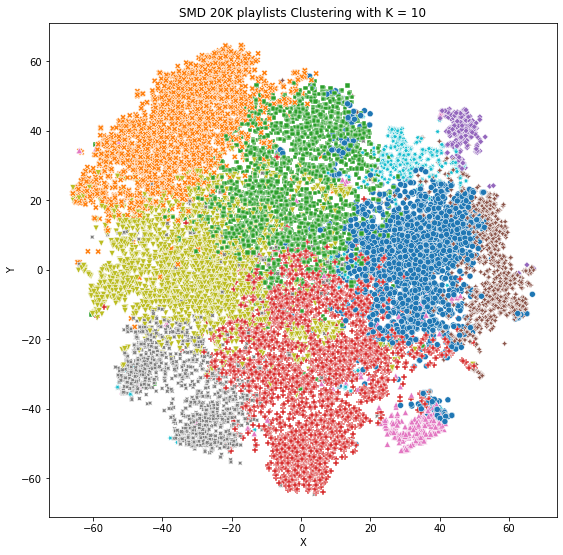

In [29]:
# KMeans with K = 10
single_model_and_plot(KMeans, K=10, df=scaled_data, df_clusters=df_opentsne, 
                      title='Clustering on scaled data', random_state=None)

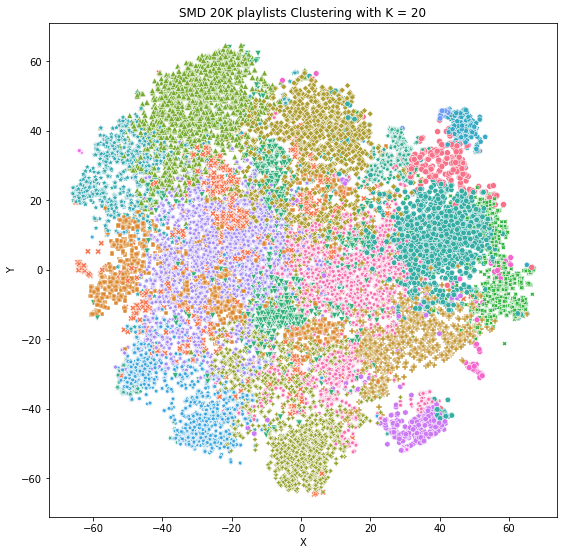

In [30]:
# KMeans with K = 20
single_model_and_plot(KMeans, K=20, df=scaled_data, df_clusters=df_opentsne, 
                      title='Clustering on scaled data', random_state=None)

### Model Training - to find K

#### T.B.D